# Comunicados de Política Monetaria
## Parte 1.

En este notebook crearemos un pandas DataFrame con las decisiones de política monetaria de Banxico y haremos un análisis de la información recabada.

In [121]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from requests_html import HTMLSession
from collections import defaultdict
from unidecode import unidecode
from datetime import datetime
import PyPDF2
import os
from tqdm import tqdm
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode
from nltk import corpus
from collections import defaultdict
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [196]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (12, 4)

La información de decisción de política monetaria se encuentra en la siguiente url.

In [197]:
url = ("https://www.banxico.org.mx/publicaciones-y-prensa/"
      "anuncios-de-las-decisiones-de-politica-monetaria/"
      "anuncios-politica-monetaria-t.html")

* Entra a `url` y analiza la página.

In [198]:
print(url)

https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/anuncios-politica-monetaria-t.html


* Como podemos observar, la url objetivo contiene
    * las fechas de decisiones de política monetaria,
    * el resumen de las decisiones de política monetaria y
    * una url que nos dirige a un pdf con el texto completo del Anuncio de Política Monetaria.
    
<h3 style="color:crimson">Ejercicio</h3>

1. Por medio de `requests_html`, extrae los tres puntos antes mencionados y guárdalos dentro de un DataFrame con columnas `"date"`, `"text"` y `"url"`;
2. Con el dataframe seleccionado, filtra todos comunicados anteriores al 15 de febrero de 2008, i.e., queremos todos los comunicados a partir del 15 de Febrero de 2008;
3. Guarda tu DataFrame dentro de un archivo `.pkl` con nombre `comunicados-banxico.pkl`: **hint:** Revisa el uso del método `to_pickle`.

In [199]:
with HTMLSession() as sess:
    r=sess.get(url)

r

<Response [200]>

In [200]:
table = r.html.find("tr")

In [201]:
table[0].find("td[class='bmdateview']", first = True).text

'13/02/20'

In [202]:
table[0].find("td[class='bmtextview']", first = True).text

'El objetivo para la Tasa de Inter�s Interbancaria a 1 d�a (tasa objetivo) disminuye en 25 puntos base\nTexto completo'

In [203]:
table[0].find("td[class='bmtextview']", first = True).absolute_links

{'https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{F2570B49-2124-CAD3-09A5-380DC3E4CD0C}.pdf'}

In [204]:
def extract_info(row):
    date_text = row.find("td[class='bmdateview']", first = True).text
    date = datetime.strptime(date_text,"%d/%m/%y")
    text = row.find("td[class='bmtextview']", first = True).text
    url, *_ = row.find("td[class='bmtextview']", first = True).absolute_links
    
    return {
        "fecha": date,
        "text": text,
        "url": url
    }

In [205]:
extract_info(table[0])

{'fecha': datetime.datetime(2020, 2, 13, 0, 0),
 'text': 'El objetivo para la Tasa de Inter�s Interbancaria a 1 d�a (tasa objetivo) disminuye en 25 puntos base\nTexto completo',
 'url': 'https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{F2570B49-2124-CAD3-09A5-380DC3E4CD0C}.pdf'}

In [206]:
info = [extract_info(row) for row in table]
df = pd.DataFrame(info).set_index('fecha').sort_index(ascending = True)
df_after = df.loc["2008-02-15":]
df_after.head()

,text,url
fecha,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...


In [207]:
df_after.to_pickle("df_banxico.pkl")

<h3 style="color:crimson">Ejercicio</h3>

Por medio del método `str.extract` para un pandas Series, crea una nueva columna `"category"` que extraiga del texto si la tasa se 
1. `"mantiene"`
2. `"incrementa"`
3. `"disminuye"`

In [208]:
df_after = (df_after.join(df_after["text"].str.extract(r'(mantiene|incrementa|disminuye)')[0].rename("category"), 
                          how = "left"))

In [209]:
df_after.head()

,text,url,category
fecha,,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,incrementa


<h3 style="color:crimson">Ejercicio</h3>

Cuenta las veces en las que la tasa se mantuvo, se incrementó o se disminuyó.

In [210]:
df_after["category"].value_counts()

mantiene      72
incrementa    18
disminuye     16
Name: category, dtype: int64

<h3 style="color:crimson">Ejercicio</h3>

Reproduce la siguiente figura sobre los comunicados de prensa de Banxico:
1. La gráfica de la izquierda representa una serie de tiempo sobre los comunicados de banxico. Si `y=1`, la tasa de referencia se incrementó; si `y=0`, la tasa se mantuvo; finalmente, si `y=-1`, la tasa disminuyó.
2. La gráfica de la derecha es una gráfica de barras del ejercicio anterior

In [213]:
df_after.loc[df_after['category'] == 'mantiene', 'category_num'] = 0
df_after.loc[df_after['category'] == 'incrementa', 'category_num'] = 1
df_after.loc[df_after['category'] == 'disminuye', 'category_num'] = -1

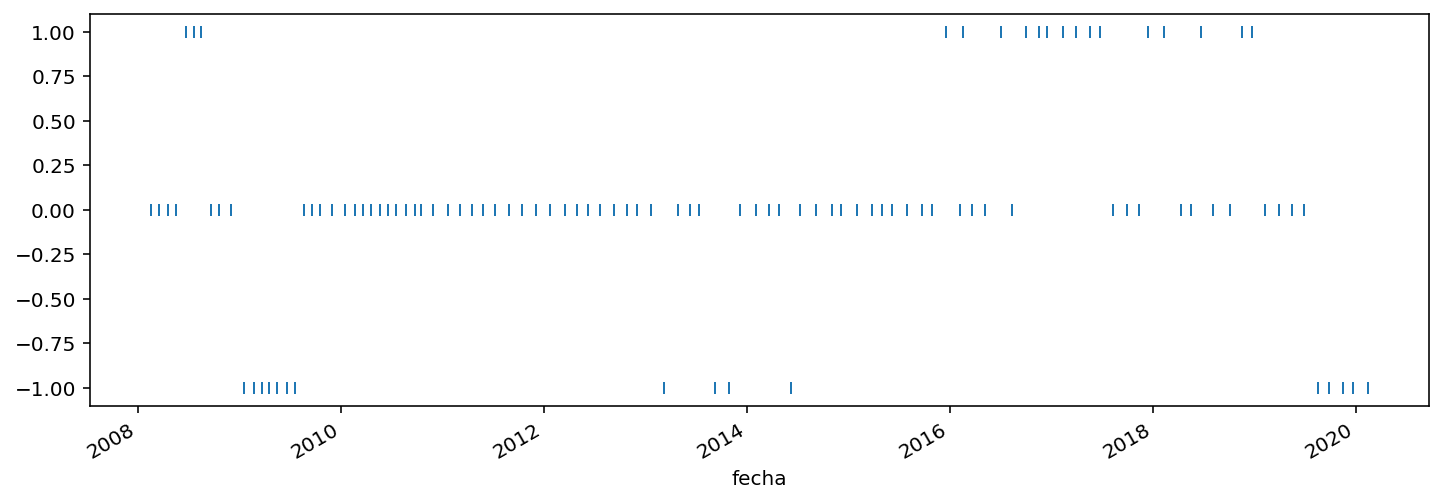

In [230]:
df_after["category_num"].plot(marker='|', linestyle="")

In [238]:
df_after["category"].value_counts()

mantiene      72
incrementa    18
disminuye     16
Name: category, dtype: int64

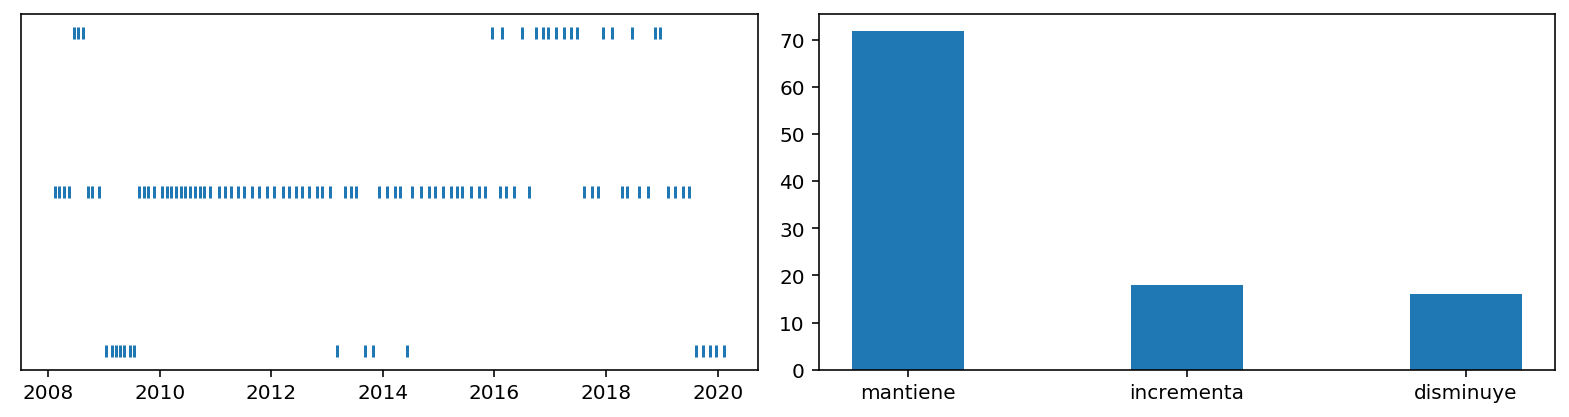

In [270]:

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(11,3))
axs[0].scatter(x = df_after.index, y = df_after["category_num"],
               marker = "|")
axs[0].yaxis.set_visible(False)
axs[1].bar(x = df_after["category"].value_counts().index, 
           height = df_after["category"].value_counts(),
          width = 0.4)
plt.show()

<h3 style="color:crimson">Ejercicio</h3>

Agrupa por año y cuenta el número de comunicados en un año para cada categoría.

In [176]:
df_group = df_after.groupby([df_after.index.strftime("%Y"),"category"])["category"].count()
df_group

fecha  category  
2008   incrementa     3
       mantiene       7
2009   disminuye      7
       mantiene       4
2010   mantiene      11
2011   mantiene       8
2012   mantiene       8
2013   disminuye      3
       mantiene       5
2014   disminuye      1
       mantiene       7
2015   incrementa     1
       mantiene       7
2016   incrementa     5
       mantiene       4
2017   incrementa     5
       mantiene       3
2018   incrementa     4
       mantiene       4
2019   disminuye      4
       mantiene       4
2020   disminuye      1
Name: category, dtype: int64

<h3 style="color:crimson">Ejercicio</h3>

Con el resultado anterior, replica la siguiente gráfica

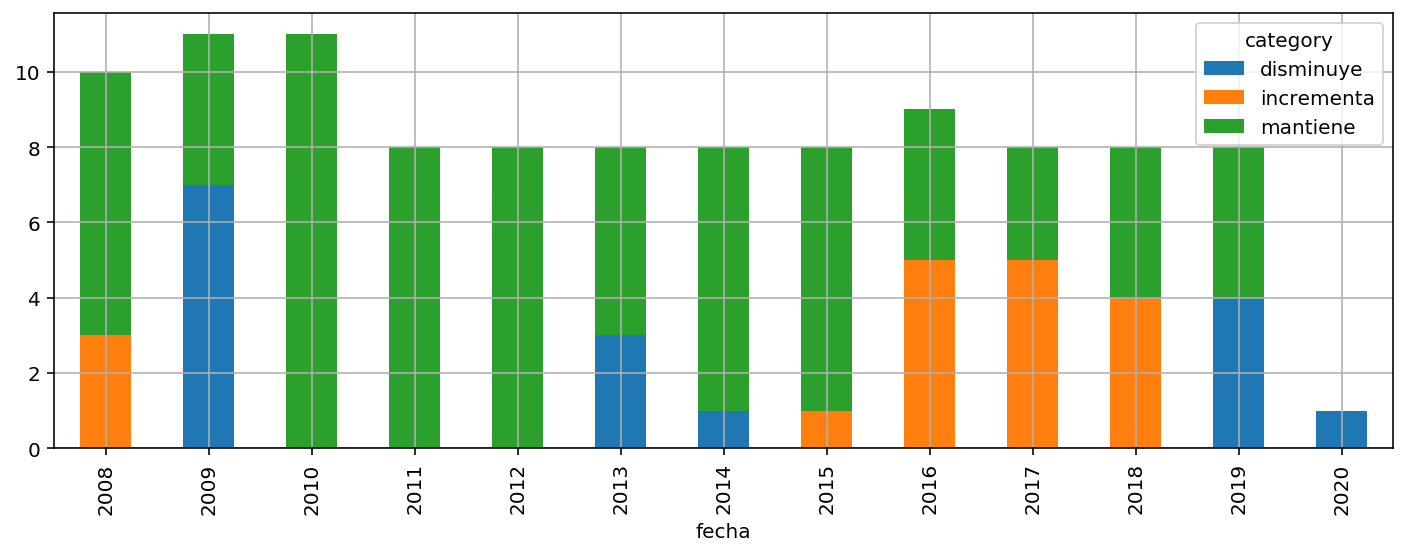

In [180]:
df_group.unstack().fillna(0).plot(kind='bar', stacked = True, grid = True)

 ## Crear carpeta para descarga  

In [4]:
import os

In [ ]:
from io import ByteIO

In [18]:
url = 'https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{F2570B49-2124-CAD3-09A5-380DC3E4CD0C}.pdf'
name = "metadata.pdf"
if not os.path.exists("downloads"):
    os.mkdir("downloads")
full_path = os.path.join("downloads", name)
download_pdf(url, full_path)

# Download pdf's from urls

In [50]:
import requests

In [89]:
def download_pdf(url, folder, name):
    pdf_name = name + ".pdf"
    response = requests.get(url)
    full_path = os.path.join(folder, pdf_name)
    with open(full_path, 'wb') as f:
        f.write(response.content)

In [78]:
url = 'https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/%7BA020627B-C6CC-C74D-02C8-42D99B9B6B29%7D.pdf'
date = '2008-02-15'

download_pdf(url, "downloads", date)


In [105]:
for index, row in tqdm(df_banxico.iterrows()):
    download_pdf(row["url"], "downloads", index.strftime("%Y-%m-%d"))

106it [00:09, 11.00it/s]


# Reading PDF's

In [110]:
df_banxico = pd.read_pickle("df_banxico.pkl")

In [114]:
df_banxico = (df_banxico.join(df_banxico["text"].str.extract(r'(mantiene|incrementa|disminuye)')[0].rename("category"), 
                          how = "left"))

In [115]:
df_banxico

,text,url,category
fecha,,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,incrementa
...,...,...,...
2019-08-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye
2019-09-26,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye
2019-11-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye


In [141]:
def read_pdf(name, folder= ""):
    text = []
    full_path = os.path.join(folder, name)

    with open(full_path, mode='rb') as f:
        reader = PyPDF2.PdfFileReader(f)
        num_pages = reader.getNumPages()
        for num_page in range(num_pages):
            page = reader.getPage(num_page)
            text.append(page.extractText())
    text_pdf= " ".join(text)
    uni_text_pdf = unidecode(text_pdf)
    
    return {"date" : name[:-4],
    "content" : uni_text_pdf    
    }

In [142]:
folder = "downloads"
pdf_list = []
for index, row in tqdm(df_banxico.iterrows()):
    name = index.strftime("%Y-%m-%d")+ ".pdf"
    pdf_content = read_pdf(name, folder)
    pdf_list.append(pdf_content)
    
    
    

In [143]:
df_pdf = pd.DataFrame.from_records(pdf_list).set_index('date').sort_index(ascending = True)

In [144]:
df_pdf

,content
date,
2008-02-15,15 de Febrero de 2008 Comunicado de Prensa ...
2008-03-14,14 de Marzo de 2008 Comunicado de Prensa An...
2008-04-18,18 de Abril de 2008 \nComunicado de Prensa Anu...
2008-05-16,16 de mayo de 2008 Comunicado de Prensa Anunc...
2008-06-20,20 de junio de 2008 Comunicado de Prensa Anun...
...,...
2019-08-15,1 15 de agosto de 2019\n Comunicado de Pren...
2019-09-26,1 26 de \nseptiembre\n de 2019\n Comunicado...
2019-11-14,1 14 de \nnoviembre\n de 201\n9 Comunicado d...


# Final Pandas Data Frame 

In [145]:
df_final = df_banxico.join(df_pdf, how = "left")

In [153]:
df_final.to_pickle("df_final.pkl")

# Limpieza de texto

In [524]:
df_final = pd.read_pickle("df_final.pkl")

In [401]:
dict_final = df_final.to_dict('records')

In [467]:
df_final.head(4)

,text,url,category,content
fecha,,,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,15 de Febrero de 2008 Comunicado de Prensa ...
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,14 de Marzo de 2008 Comunicado de Prensa An...
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,18 de Abril de 2008 \nComunicado de Prensa Anu...
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,16 de mayo de 2008 Comunicado de Prensa Anunc...


In [468]:
df_final.content[0]

' 15 de Febrero de 2008 Comunicado de Prensa    Anuncio de Politica Monetaria  La Junta de Gobierno del Banco de Mexico ha\n decidido mantener sin cambio el objetivo \npara la Tasa de Interes Interbancaria a 1 dia, en 7.5 por ciento. \n Las perspectivas para el crecimiento de la ec\nonomia mundial han continuado deteriorandose.  La \nactividad economica en Japon y en Europa se ha debilitado.  La desaceleracion ha sido mas \n\npronunciada en Estados Unidos y se\n han acrecentado los riesgos de \nque ocurra una recesion en la \nprimera mitad del ano en curso.  Ello, como cons\necuencia de la crisis del mercado hipotecario y \nsus repercusiones en el sector financiero, en \notros segmentos del mercado crediticio, y en la \nconfianza de los consumidores.  El dinamismo \ndel resto de las economias seria afectado por una \ndesaceleracion estadounidense acentuada.  Al\n mismo tiempo, han persistido las presiones \ninflacionarias derivadas del alza de\n los precios internacionales de los alime

In [526]:
def limpia_dialogo(doc):
    limpio = doc.lower()
    limpio =re.sub("[^\w ]", "", limpio)
    return limpio

In [527]:
df_final["clean"] = (df_final["content"]
                       .apply(lambda x : limpia_dialogo(x)))

In [528]:
df_final.clean[0]

' 15 de febrero de 2008 comunicado de prensa    anuncio de politica monetaria  la junta de gobierno del banco de mexico ha decidido mantener sin cambio el objetivo para la tasa de interes interbancaria a 1 dia en 75 por ciento  las perspectivas para el crecimiento de la economia mundial han continuado deteriorandose  la actividad economica en japon y en europa se ha debilitado  la desaceleracion ha sido mas pronunciada en estados unidos y se han acrecentado los riesgos de que ocurra una recesion en la primera mitad del ano en curso  ello como consecuencia de la crisis del mercado hipotecario y sus repercusiones en el sector financiero en otros segmentos del mercado crediticio y en la confianza de los consumidores  el dinamismo del resto de las economias seria afectado por una desaceleracion estadounidense acentuada  al mismo tiempo han persistido las presiones inflacionarias derivadas del alza de los precios internacionales de los alimentos destaca el alza reciente del trigo y de los e

## Stopwords

In [893]:
stopwords = corpus.stopwords.words("spanish")
stopwords =[unidecode(word) for word in stopwords]

stopwords.append("inflacion")
stopwords.append("mexico")
stopwords.append("economia")
stopwords.append("politica")
stopwords.append("precios")
stopwords.append("monetaria")
stopwords.append("riesgos")
stopwords.append("ciento")
stopwords.append("economica")
stopwords.append("interes")
stopwords.append("crecimiento")
stopwords.append("objetivo")
stopwords.append("actividad")
stopwords.append("tasa")
stopwords.append("junta")
stopwords.append("asi")
stopwords.append("ano")
stopwords.append("gobierno")
stopwords.append("subyacente")
stopwords.append("2017")
stopwords.append("2018")


In [841]:
#df_final['rbow'] = df_final['clean'].apply(lambda x: [item for item in x.split() if item not in stopwords])
#df_final

# Model 

In [1045]:
seed = 321

In [1046]:
D1 = df_final[df_final["category"]=="mantiene"]["clean"].values
D2 = df_final[df_final["category"]=="disminuye"]["clean"].values
D3 = df_final[df_final["category"]=="incrementa"]["clean"].values

In [1047]:
D1_train, D1_test = train_test_split(D1, test_size=0.2, random_state = seed)
D2_train, D2_test = train_test_split(D2, test_size=0.2, random_state = seed)
D3_train, D3_test = train_test_split(D3, test_size=0.2, random_state = seed)

In [1048]:
V1 = [palabra for pdf in D1_train for palabra in pdf.split() if palabra not in stopwords]
V2 = [palabra for pdf in D2_train for palabra in pdf.split() if palabra not in stopwords]
V3 = [palabra for pdf in D3_train for palabra in pdf.split() if palabra not in stopwords]


In [1049]:
N1 = len(D1_train)
N2 = len(D2_train)
N3 = len(D3_train)
N = N1 + N2 + N3

In [1050]:
N

83

In [1051]:
len(set(V1))/len(V1)

0.11130720295505848

In [1052]:
len(set(V2))/len(V2)

0.2639074321317312

In [1053]:
len(set(V3))/len(V3)

0.20813153199082335

In [1054]:
from collections import Counter

In [1055]:
Counter(V1).most_common(10)

[('expectativas', 166),
 ('3', 158),
 ('parte', 154),
 ('unidos', 153),
 ('cambio', 143),
 ('baja', 141),
 ('plazo', 140),
 ('general', 137),
 ('mantener', 136),
 ('economias', 132)]

In [1056]:
Counter(V2).most_common(10)

[('base', 35),
 ('nivel', 35),
 ('mayor', 33),
 ('baja', 33),
 ('banco', 32),
 ('condiciones', 30),
 ('mundial', 28),
 ('parte', 28),
 ('puntos', 27),
 ('balance', 27)]

In [1057]:
Counter(V3).most_common(10)

[('expectativas', 71),
 ('plazo', 60),
 ('mediano', 59),
 ('unidos', 58),
 ('largo', 54),
 ('parte', 45),
 ('bien', 43),
 ('nacional', 42),
 ('nivel', 41),
 ('entorno', 40)]

In [1058]:
V = set(V1)|set(V2)|set(V3)
vocab = pd.DataFrame(index=V)

In [1059]:
V1_c = pd.Series(V1, name='k1').value_counts()
V2_c = pd.Series(V2, name='k2').value_counts()
V3_c = pd.Series(V3, name='k3').value_counts()

In [1060]:
#likelihood
L = (vocab.join(V1_c, how = "left")
    .join(V2_c, how = "left")
    .join(V3_c, how = "left"))
L = L.fillna(0) + 1
L = L/L.sum(axis = 0)
L.sort_values("k1", ascending= False)
L.sample(10, random_state=314)

,k1,k2,k3
inducida,0.000182,0.000131,0.000091
elevacion,0.000109,0.000131,0.000091
internas,0.000073,0.000653,0.000182
incluidas,0.000036,0.000131,0.000182
fuerza,0.000109,0.000131,0.000091
419,0.000036,0.000261,0.000091
algun,0.000218,0.000131,0.000182
cifra,0.000145,0.000261,0.000272
demanda,0.002870,0.002220,0.002089
presentando,0.000799,0.000522,0.000545


In [1061]:
log_L = np.log(L)
log_L.sample(10, random_state=314)

,k1,k2,k3
inducida,-8.613557,-8.943506,-9.306559
elevacion,-9.124383,-8.943506,-9.306559
internas,-9.529848,-7.334068,-8.613412
incluidas,-10.222995,-8.943506,-8.613412
fuerza,-9.124383,-8.943506,-9.306559
419,-10.222995,-8.250359,-9.306559
algun,-8.431236,-8.943506,-8.613412
cifra,-8.836701,-8.250359,-8.207947
demanda,-5.853547,-6.110293,-6.171065
presentando,-7.131953,-7.557212,-7.514800


In [1062]:
log_prior_k1 = np.log(N1 / N)
log_prior_k2 = np.log(N2 / N)
log_prior_k3 = np.log(N3 / N)
log_priors= np.array([log_prior_k1,log_prior_k2, log_prior_k3])

In [1063]:
D_test = D1_test.tolist() + D2_test.tolist() + D3_test.tolist()
y_test = ["k1"] * len(D1_test) + ["k2"] * len(D2_test)  + ["k3"] * len(D3_test) 

In [1064]:
D_test[22]

'20 de junio de 2008 comunicado de prensa  anuncio de politica monetaria  la junta de gobierno del banco de mexico ha decidido incrementar a 775 por ciento el objetivo para la tasa de interes interbancaria a 1 dia  la economia mundial continua desacelerandose y la actividad economica en estados unidos se mantiene debil a este respecto se vislumbra un periodo prolongado de ajuste en ese pais conforme se reconstituya el ahorro de los hogares al mismo tiempo se han intensificado las presiones inflacionarias en el mundo debido a los fuertes incrementos en los precios de los alimentos de los energeticos y de otras materias primas  practicamente todos los bancos centrales han revisado al alza sus previsiones sobre la inflacion  algunos en los principales paises desarrollados han expresado su creciente preocupacion por el deterioro inflacionario otros en numerosos paises de economias emergentes han endurecido su politica monetaria  durante el primer trimestre la actividad economica en mexico 

In [1065]:
y_hat_test = []
for d_test in D_test:
    f = set([palabra for palabra in d_test.split() if palabra in V])
    res = log_L.loc[f].sum(axis=0) + log_priors
    print(res.idxmax())
    y_hat_test.append(res.idxmax())

k1
k1
k1
k1
k1
k1
k1
k1
k1
k1
k1
k1
k1
k1
k1
k2
k2
k2
k1
k3
k3
k3
k1


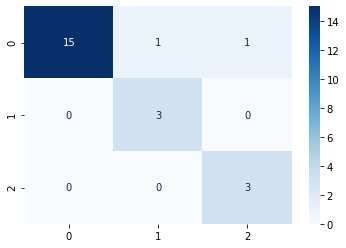

In [1067]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_hat_test,y_test ),annot=True, cmap= "Blues")